In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
import time

from scipy.stats import norm,skew
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from helper import outlier_treatment,count_percentage_mean,customize_scatter_plot,customize_box_plot,customize_cross_tab,customize_strip_plot
from sklearn.model_selection import KFold, cross_val_score,train_test_split,GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, LassoCV, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv("./data/trainingData.csv")
df.shape

(40000, 21)

In [3]:
pd.DataFrame(df.dtypes).rename(columns={0:'dtype'})

,dtype
Id,int64
city,object
age,int64
sex,object
social_class,object
primary_business,object
secondary_business,object
annual_income,float64
monthly_expenses,float64
old_dependents,int64


* There are multiple types of features
* Out of 21 features 7 of the features are object(includes string values in the variable)
* Correct the spell of water_availabity columns

In [4]:
df = df.rename({"water_availabity": "water_availability"}, axis=1)
df.describe() 

,Id,age,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,occupants_count,house_area,sanitary_availability,water_availability,loan_tenure,loan_installments,loan_amount
count,40000.00000,40000.00000,4.000000e+04,39880.000000,40000.000000,40000.00000,39621.000000,40000.000000,40000.000000,39792.000000,34747.000000,40000.000000,40000.000000,4.000000e+04
mean,20000.50000,55.15990,3.764021e+04,3810.875401,0.044900,1.13710,0.972489,26.641000,552.804750,0.686369,0.753216,12.032225,21.761175,8.412593e+03
std,11547.14972,3830.35566,2.873912e+04,4592.958009,0.222003,1.07384,0.163568,4749.995485,4596.921905,0.464028,0.255337,1.367473,16.682458,1.359694e+04
min,1.00000,2.00000,0.000000e+00,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-1.000000,-1.000000,3.000000,0.000000,1.000000e+02
25%,10000.75000,29.00000,1.440000e+04,2500.000000,0.000000,0.00000,1.000000,2.000000,200.000000,0.000000,0.500000,12.000000,12.000000,5.000000e+03
50%,20000.50000,35.00000,3.600000e+04,3500.000000,0.000000,1.00000,1.000000,3.000000,400.000000,1.000000,1.000000,12.000000,12.000000,8.000000e+03
75%,30000.25000,42.00000,5.600000e+04,4000.000000,0.000000,2.00000,1.000000,4.000000,600.000000,1.000000,1.000000,12.000000,50.000000,1.000000e+04
max,40000.00000,766105.00000,1.200000e+06,240000.000000,3.000000,7.00000,1.000000,950000.000000,700000.000000,1.000000,1.000000,84.000000,84.000000,1.343000e+06


### Initial observation
* Id,age, annual_income, monthly_expenses, house_area, loan_amount are continuous variable 
* There are unrealistic values for age(max=766105), occupants_count(max=950000), house_area(max=700000),loan_amount( rural small scale bussiness looking for loan amount over 25L)
* home_ownership, sanitary_availability, water_availabity are nominal features
* old_dependents, old_dependents, loan_tenure, loan_installments are Ordinal features

In [5]:
# Missing data

total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
social_class,5255,0.131375
water_availability,5253,0.131325
secondary_business,5241,0.131025
city,1864,0.046600
type_of_house,694,0.017350
home_ownership,379,0.009475
sanitary_availability,208,0.005200
monthly_expenses,120,0.003000
loan_purpose,26,0.000650
primary_business,26,0.000650


* Some features have missing values which needs the data imputation

###  Response variable `loan_amount` distribution

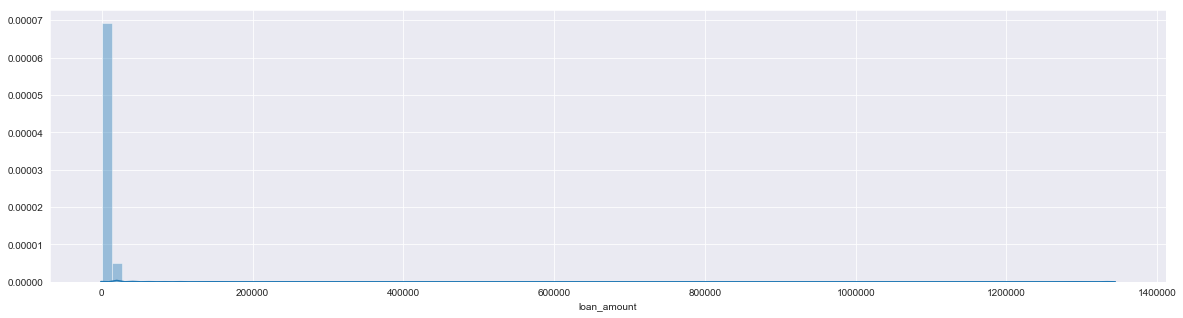

In [6]:
plt.figure(figsize=[20,5])
sns.distplot(df.loan_amount, bins=100)
plt.show()

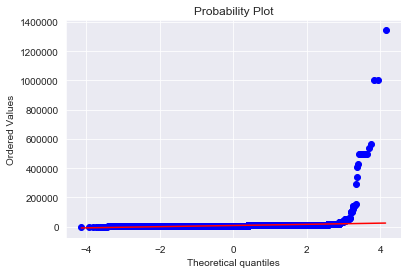

Skewness: 57.873098
Kurtosis: 4258.706925


In [7]:
stats.probplot(df.loan_amount, plot=plt)
plt.show()
print("Skewness: %f" % df['loan_amount'].skew())
print("Kurtosis: %f" % df['loan_amount'].kurt())

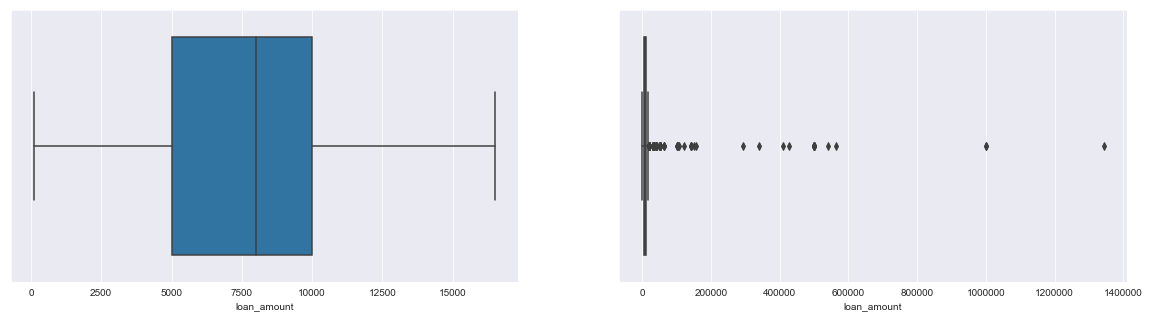

In [8]:
f,ax = plt.subplots(1,2, figsize=(20,5))
sns.boxplot(df.loan_amount, showfliers=False, ax=ax[0])
sns.boxplot(df.loan_amount, showfliers=True, ax=ax[1])
plt.show()

* target variable, loan_amount is not normally distributed.
* target variable is right-skewed. (skewness is less than -1 or greater than 1, the data are considered to be highly skewed)
* There are multiple outliers in the variable.

Can be fixed by using different types of transformation and outlier treatment. However, before doing that, I want to find out the relationships among the target variable and other predictor variables. 

#### Outlier treatment

In [9]:
lowerbound,upperbound = outlier_treatment(df.loan_amount)

print("Lower loan amount range", lowerbound)
print("Upper loan amount range", upperbound)

df[(df.loan_amount < lowerbound) | (df.loan_amount > upperbound)].shape

Lower loan amount range -2500.0
Upper loan amount range 17500.0


(203, 21)

Remove the data points which are lower than lowerbound and higher than the upperbound

In [10]:
df_clean = df.copy()
df_clean.drop(df_clean[(df_clean.loan_amount > upperbound) | (df_clean.loan_amount < lowerbound) ].index, inplace=True)

Skewness: 0.600687


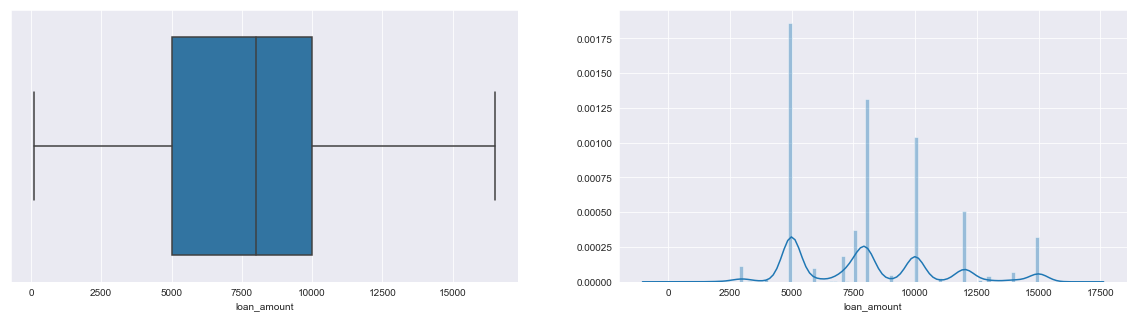

In [11]:
f,ax = plt.subplots(1,2, figsize=(20,5))
sns.boxplot(df_clean.loan_amount, showfliers=False, ax=ax[0])
sns.distplot(df_clean.loan_amount, bins=100,ax=ax[1])
print("Skewness: %f" % df_clean['loan_amount'].skew())

After the outlier removal skewness is reduced (skewness is between -1 and – 0.5 or between 0.5 and 1, the data are considered to be moderately skewed) but its evident that distribution is not normal 


## Predictor variable analysis

* Droping the ID coloum as it is ordered number assigned to the applicants and not contributing to the predictions of the loan amount

In [12]:
df = df.drop(['Id'], axis=1)
df_clean = df_clean.drop(['Id'], axis=1)

In [13]:
## Getting the correlation of all the features with target variable without the outlier removal. 
(df.corr()**2)["loan_amount"].sort_values(ascending = False)[1:]

annual_income            7.332788e-03
loan_tenure              6.761800e-03
water_availability       6.385573e-03
sanitary_availability    1.784274e-03
monthly_expenses         3.829620e-04
loan_installments        2.553856e-04
old_dependents           4.895466e-05
young_dependents         3.844214e-05
house_area               8.261334e-06
age                      3.876064e-06
home_ownership           3.758489e-06
occupants_count          1.556093e-08
Name: loan_amount, dtype: float64

In [14]:
## Getting the correlation of all the features with target variable with the outlier. 
(df_clean.corr()**2)["loan_amount"].sort_values(ascending = False)[1:]

annual_income            9.253417e-02
water_availability       8.824051e-02
sanitary_availability    2.711724e-02
loan_installments        1.848965e-02
loan_tenure              1.528839e-02
young_dependents         1.280999e-02
home_ownership           2.338314e-03
monthly_expenses         1.531655e-03
old_dependents           7.707486e-04
house_area               2.812597e-04
age                      6.996695e-05
occupants_count          3.877409e-12
Name: loan_amount, dtype: float64

These are the predictor variables sorted in a descending order starting with the most correlated one **annual_income**. Let's put this one in a scatter plot and see how it looks.

### Predictor variable `annual_income`

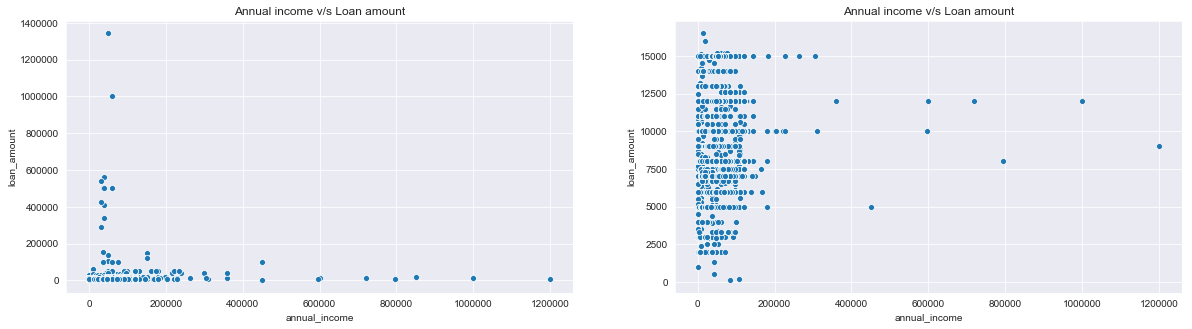

In [15]:
customize_scatter_plot(df=df, 
                       df_clean=df_clean, 
                       y='loan_amount',
                       x='annual_income',
                       title='Annual income v/s Loan amount')

# Intoducing loan amount band column

df['loan_amount_band']=0
df_clean['loan_amount_band']=0

df.loc[df.loan_amount == 0, 'loan_amount_band'] = "0"
df.loc[(df.loan_amount > 0) & (df.loan_amount <= 5000), 'loan_amount_band'] = "<5K"
df.loc[(df.loan_amount > 5000) & (df.loan_amount <= 10000), 'loan_amount_band'] = "5K~10K"
df.loc[(df.loan_amount > 10000) & (df.loan_amount <= 15000), 'loan_amount_band'] = "10K~15K"
df.loc[df.loan_amount > 15000, 'loan_amount_band'] = ">15K"

df_clean.loc[df_clean.loan_amount == 0, 'loan_amount_band'] = "0"
df_clean.loc[(df_clean.loan_amount > 0) & (df_clean.loan_amount <= 5000), 'loan_amount_band'] = "<5K"
df_clean.loc[(df_clean.loan_amount > 5000) & (df_clean.loan_amount <= 10000), 'loan_amount_band'] = "5K~10K"
df_clean.loc[(df_clean.loan_amount > 10000) & (df_clean.loan_amount <= 15000), 'loan_amount_band'] = "10K~15K"
df_clean.loc[df_clean.loan_amount > 15000, 'loan_amount_band'] = ">15K"

**Annual_income** is a continuous variable.
* Anual income being lower, higher loan amount is approved this cound be because of home_ownership, house_area, age(young). 
* Even with higher annual income lower loan amount is approved this could be because of age(old), dependents, occupants_count, monthly_expenses.
* There is no linear relationship between loan amount and income

### Predictor variable `loan_tenure`
Let's understand the relation between loan_tenure and annual_income

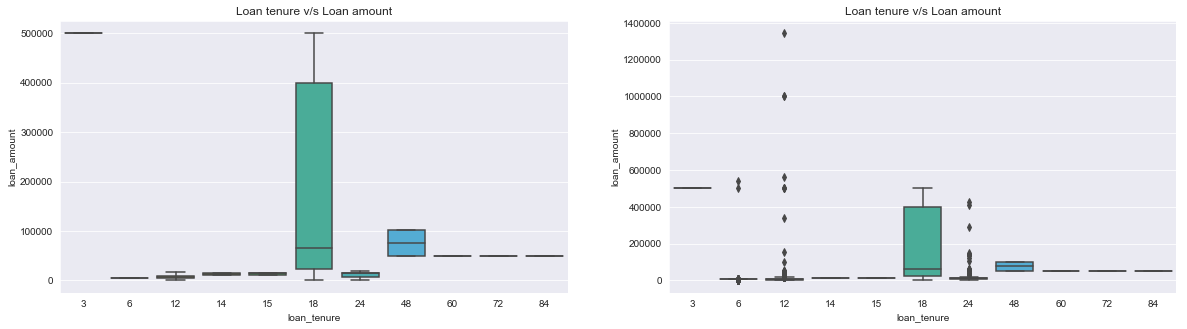

In [16]:
customize_box_plot(df, 
                   y='loan_amount',
                   x='loan_tenure',
                   title='Loan tenure v/s Loan amount')

In [17]:
count_percentage_mean(df, "loan_tenure","loan_amount")

,count,percentage,mean
loan_tenure,,,
3,2,0.000050,500000.000000
6,382,0.009550,8369.109948
12,39294,0.982350,8255.558100
14,10,0.000250,13350.000000
15,53,0.001325,13584.905660
18,6,0.000150,191683.333333
24,244,0.006100,21939.344262
48,4,0.000100,76500.000000
60,1,0.000025,50000.000000


In [18]:
count_percentage_mean(df_clean, "loan_tenure","loan_amount")

,count,percentage,mean
loan_tenure,,,
6,380,0.009548,5676.315789
12,39145,0.983617,8051.651552
14,10,0.000251,13350.000000
15,53,0.001332,13584.905660
18,1,0.000025,100.000000
24,208,0.005227,11683.653846


**loan_tenure** indicates the number of months within which loan needs to be paid. It is an ordinal varible with values ranging from 3 to 84. 
* 98% of the loan is paid within 12 months with the mean loan mount appoved less than 10K 
* Repayment of Loan amount more than 10K and less than 25K needs 12 to 24 months
* For the mean loan amount of 5L loan tenure being 3 months is not realistic(Needs outlier treatment)

### Predictor variable `water_availabity`

In [19]:
count_percentage_mean(df, "water_availability", "loan_amount")

,count,percentage,mean
water_availability,,,
-1.0,1,0.000025,8000.000000
0.0,182,0.004550,9148.351648
0.5,16782,0.419550,7647.598618
1.0,17782,0.444550,10038.955123


water_availability = -1 could be because of the data entry mistake, mode of the `water_availability` will be assigned 

In [20]:
df.loc[(df.water_availability == -1.0)] = 1
df_clean.loc[(df_clean.water_availability == -1.0)] = 1
count_percentage_mean(df, "water_availability", "loan_amount")

,count,percentage,mean
water_availability,,,
0.0,182,0.004550,9148.351648
0.5,16782,0.419550,7647.598618
1.0,17783,0.444575,10038.390654


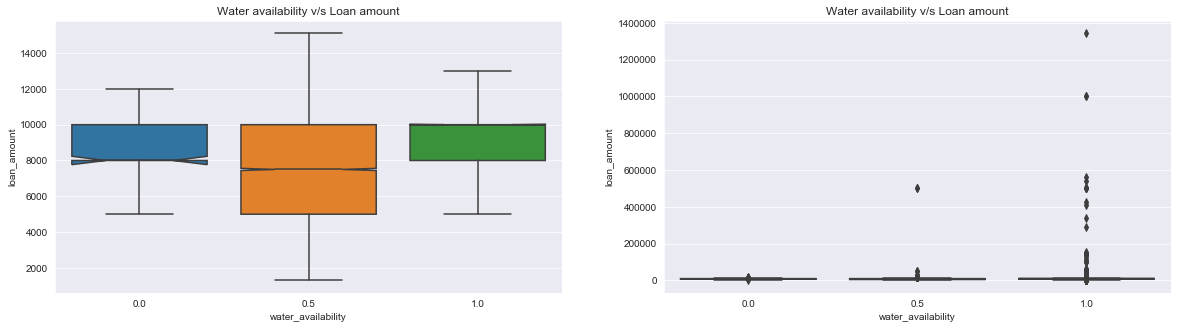

In [21]:
customize_box_plot(df, 
                   y='loan_amount',
                   x='water_availability',
                   title='Water availability v/s Loan amount',
                   notch=True)

**water_availability** can be considerd to have three levels 
* `No water available`, around 0.5% applicant belongs to this category
* `Limited water available`, around 42% applicant belongs to this category
* `Water available`, around 45% applicant belongs to this category
* For 12.5% applicant water_availability detail is missing(`Data Imputation!`)
* 50% of the `Limited water available` applicant has loan amount approved range between 5K to 10K
* Median and Q1 are all at the bottom for `No water available` and Median and Q3 are all at the top for `Water available`. Another indication that data is not normally distributed


### Predictor varibale `sanitary_availability`

In [22]:
count_percentage_mean(df, "sanitary_availability", "loan_amount")

,count,percentage,mean
sanitary_availability,,,
0.0,12478,0.31195,7573.072608
1.0,27314,0.68285,8813.809804


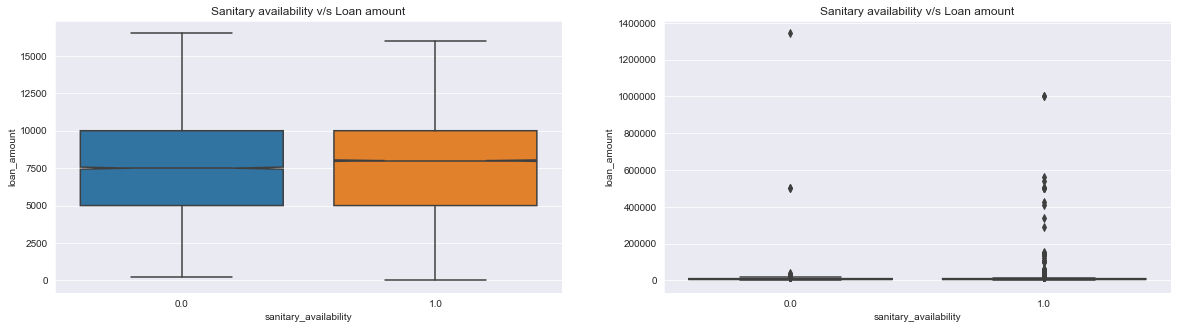

In [23]:
customize_box_plot(df, 
                   y='loan_amount',
                   x='sanitary_availability',
                   title='Sanitary availability v/s Loan amount',
                   notch=True)

**sanitary_availability** 68% of the applicant has sanitary facility. 1% of the data is missing should consider for data imputations!. There is no much difference in the average loan amount approved based on the sanitary availability. 

Lets see is there a relationship between `sanitary_availability` and `water_availability!`

In [24]:
customize_cross_tab(row_list=[df.sanitary_availability],
                    col_list=[df.water_availability])

water_availability,0.0,0.5,1.0,All
sanitary_availability,,,,
0.0,146,4403,2884,7433
1.0,36,12379,14899,27314
All,182,16782,17783,34747


* If there is water most likely(78%) that sanitary is available
* 20% of the applicant in spite of having water availability sanitary is not available

### Predictor variable `monthly_expenses`

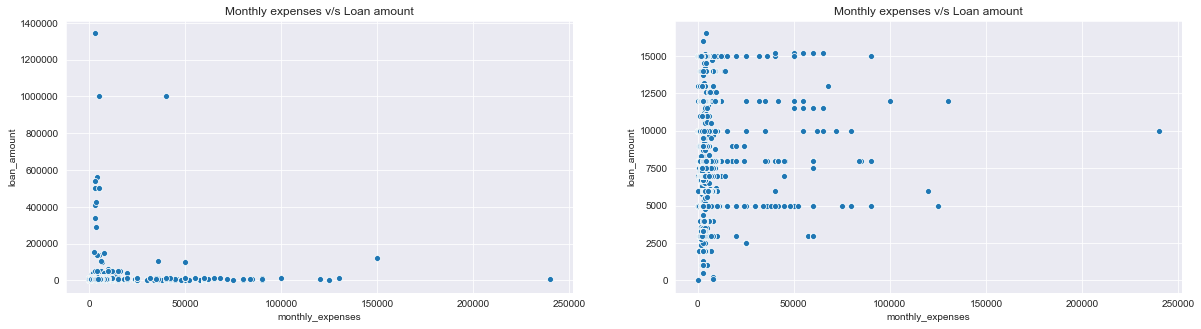

In [25]:
customize_scatter_plot(df=df, 
                       df_clean=df_clean, 
                       y='loan_amount',
                       x='monthly_expenses',
                       title='Monthly expenses v/s Loan amount')

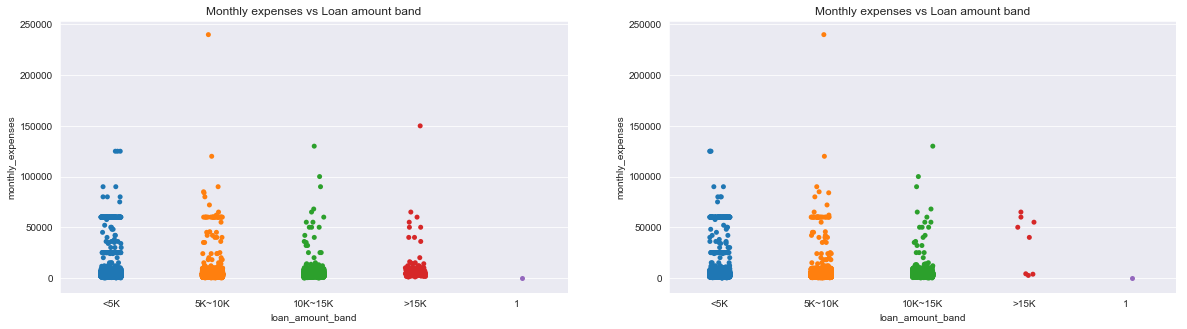

In [26]:
customize_strip_plot(df=df,
                     df_clean=df_clean,
                     y='monthly_expenses', 
                     x='loan_amount_band', 
                     title='Monthly expenses vs Loan amount band')

* There is no linear relationship between monthly expenses and loan amount
* Lower expenses applicant can get either lower amount or highr amount depends on other factors

### Predictor variable `loan_installments`

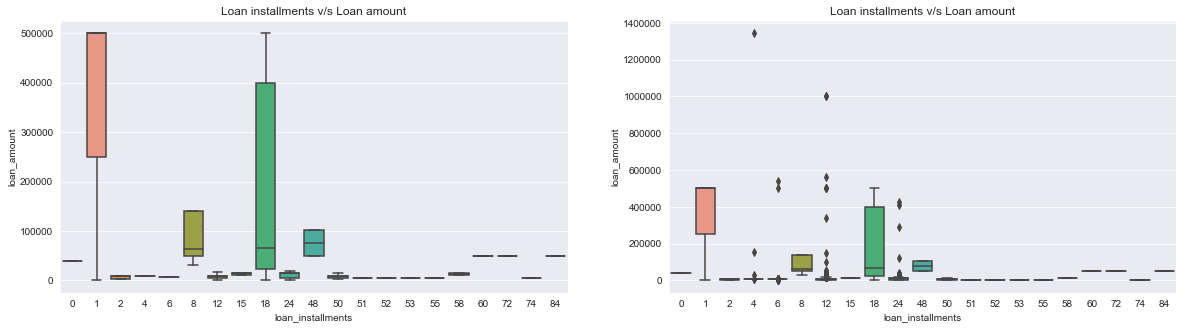

In [27]:
customize_box_plot(df, 
                   y='loan_amount',
                   x='loan_installments',
                   title='Loan installments v/s Loan amount')

In [28]:
count_percentage_mean(df, "loan_installments","loan_amount")

,count,percentage,mean
loan_installments,,,
0,1,0.000025,40000.000000
1,3,0.000075,333333.666667
2,94,0.002350,6808.510638
4,15,0.000375,109733.333333
6,344,0.008600,9031.976744
8,12,0.000300,84833.333333
12,28979,0.724475,8044.563304
15,53,0.001325,13584.905660
18,6,0.000150,191683.333333


**loan_installments** paid and **loan_tenure** must be same or less(Early payment or concention) for anyone to get good credit score. Looks like applicants had dues and have taken more time to pay the loan than the prescribed tenure. 

Lets Identify the number of months by which the repayment is delayed. As there are no missing data in both the variables subtraction should give the **n_repayment_due**. 

In [29]:
df['n_repayment_due']=0
df_clean['n_repayment_due']=0

df['n_repayment_due'] = df.loan_installments - df.loan_tenure 
df_clean['n_repayment_due'] = df_clean.loan_installments - df_clean.loan_tenure 

In [30]:
count_percentage_mean(df_clean, "n_repayment_due","loan_amount")

,count,percentage,mean
n_repayment_due,,,
-10,54,0.001357,10000.000000
-8,12,0.000302,9666.666667
-6,2,0.000050,5000.000000
-4,40,0.001005,2500.000000
0,29436,0.739654,7831.862379
12,1,0.000025,5000.000000
38,10097,0.253713,8759.681093
39,74,0.001859,5000.000000
40,6,0.000151,5000.000000


* 74% of the applicant have paid the loan within the tenure 
* Around 25% of the applicant had dues
* 1% of the applicant have early repaymnets

Can this be used to predict loan repayment behaviour to the applicant? Yes
Lets categorise the applicant based on the number of dues

Introducing a column **repayment_behaviour**

In [31]:
df['repayment_behaviour']=0
df_clean['repayment_behaviour']=0

df.loc[df.n_repayment_due < 0, 'repayment_behaviour'] = "Excellent"
df.loc[df.n_repayment_due == 0, 'repayment_behaviour'] = "Very_Good"
df.loc[(df.n_repayment_due > 0) & (df.n_repayment_due <= 12), 'repayment_behaviour'] = "Good"
df.loc[(df.n_repayment_due > 12) & (df.n_repayment_due <= 24), 'repayment_behaviour'] = "Fair"
df.loc[(df.n_repayment_due > 24) & (df.n_repayment_due <= 48), 'repayment_behaviour'] = "poor"
df.loc[df.n_repayment_due > 48, 'repayment_behaviour'] = "Bad"

df_clean.loc[df.n_repayment_due < 0, 'repayment_behaviour'] = "Excellent"
df_clean.loc[df.n_repayment_due == 0, 'repayment_behaviour'] = "Very_Good"
df_clean.loc[(df.n_repayment_due > 0) & (df_clean.n_repayment_due <= 12), 'repayment_behaviour'] = "Good"
df_clean.loc[(df.n_repayment_due > 12) & (df_clean.n_repayment_due <= 24), 'repayment_behaviour'] = "Fair"
df_clean.loc[(df.n_repayment_due > 24) & (df_clean.n_repayment_due <= 48), 'repayment_behaviour'] = "poor"
df_clean.loc[df.n_repayment_due > 48, 'repayment_behaviour'] = "Bad"

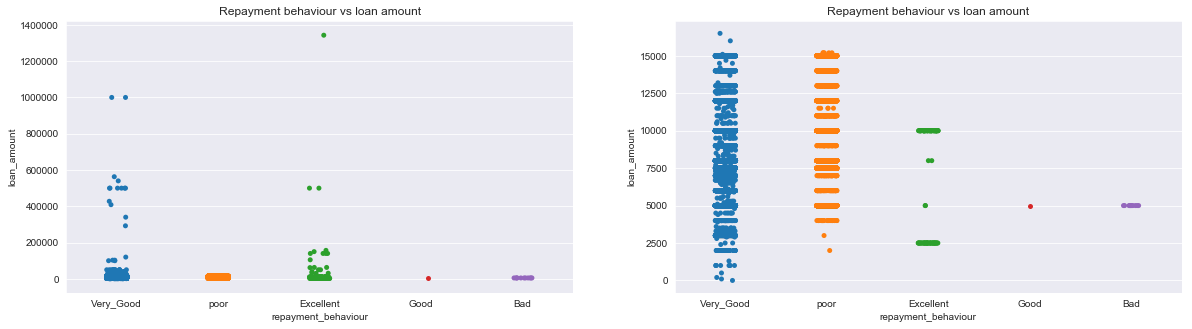

In [32]:
customize_strip_plot(df=df,
                     df_clean=df_clean,
                     y='loan_amount', 
                     x='repayment_behaviour', 
                     title='Repayment behaviour vs loan amount')

### Predictor variable `old_dependents`, `young_dependents` and `occupants_count`

In [33]:
count_percentage_mean(df_clean, "old_dependents","loan_amount")

,count,percentage,mean
old_dependents,,,
0,38148,0.958565,8038.867044
1,1528,0.038395,8453.665576
2,120,0.003015,8540.000000
3,1,0.000025,6000.000000


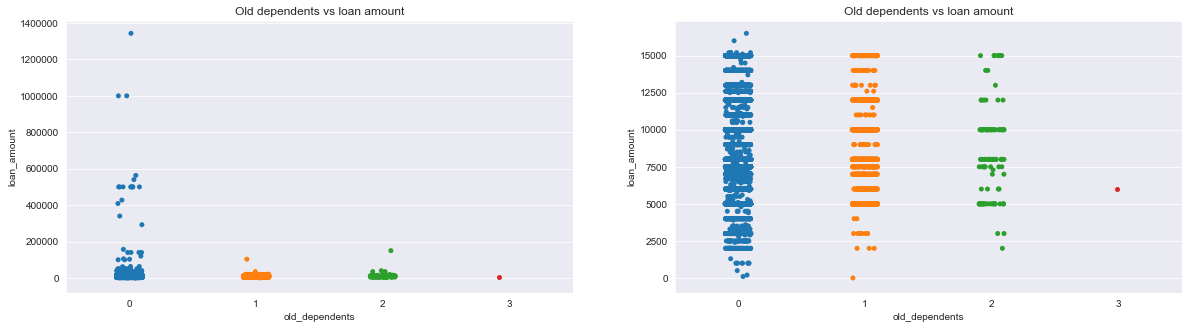

In [34]:
customize_strip_plot(df=df,
                     df_clean=df_clean,
                     y='loan_amount', 
                     x='old_dependents', 
                     title='Old dependents vs loan amount')

**old_dependents** 95% of the applicant do not have any old dependents. 

In [35]:
count_percentage_mean(df_clean, "young_dependents","loan_amount")

,count,percentage,mean
young_dependents,,,
0,14706,0.369525,7413.790290
1,9823,0.246828,8450.504021
2,11312,0.284243,8563.330976
3,3234,0.081262,8143.290043
4,610,0.015328,7420.327869
5,90,0.002261,7533.333333
6,18,0.000452,7472.222222
7,4,0.000101,8875.000000


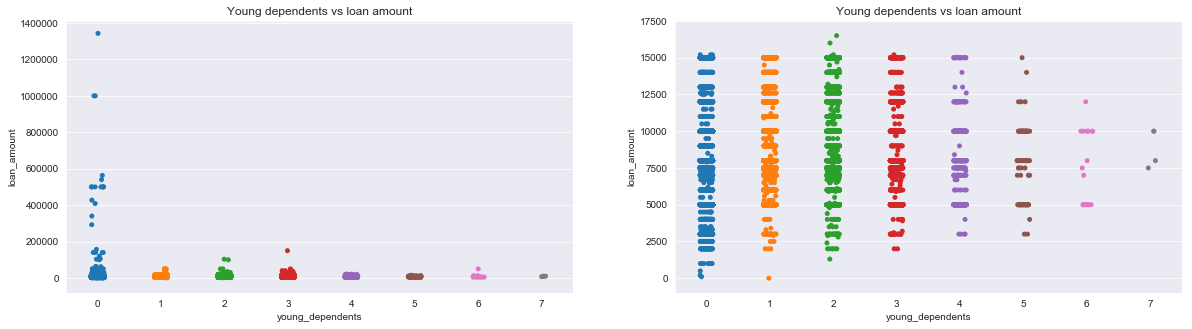

In [36]:
customize_strip_plot(df=df,
                     df_clean=df_clean,
                     y='loan_amount', 
                     x='young_dependents', 
                     title='Young dependents vs loan amount')

Higher the number **young_dependents** loan amount approved seems less than 10K

Is there a relationship between number of dependents and monthly expenses?

Lets create  **total_dependents** which is the sum of old and youn dependednt counts

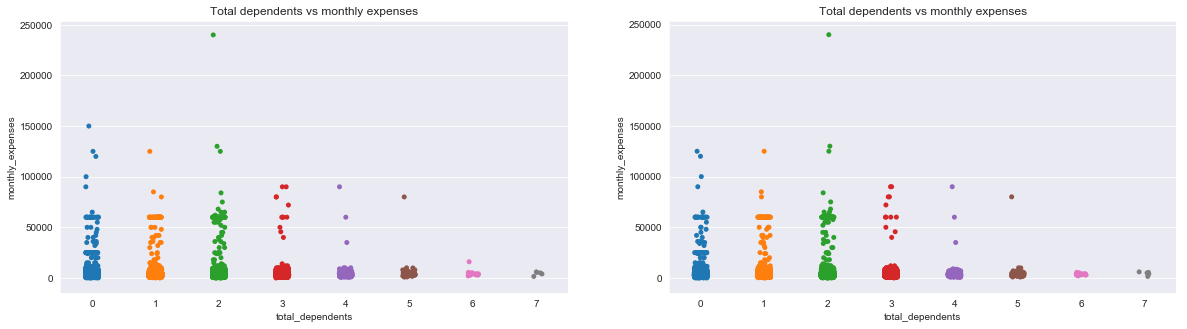

In [37]:
df['total_dependents']=0
df_clean['total_dependents']=0

df['total_dependents'] = df.old_dependents + df.young_dependents 
df_clean['total_dependents'] = df.old_dependents + df.young_dependents
customize_strip_plot(df=df,
                     df_clean=df_clean,
                     y='monthly_expenses', 
                     x='total_dependents', 
                     title='Total dependents vs monthly expenses')

In [38]:
count_percentage_mean(df_clean, "total_dependents","monthly_expenses")

,count,percentage,mean
total_dependents,,,
0,13698,0.344197,3639.951539
1,10416,0.261728,3741.498848
2,11475,0.288338,3993.851765
3,3411,0.085710,3846.640281
4,668,0.016785,3948.841317
5,104,0.002613,4592.625000
6,20,0.000503,3820.000000
7,5,0.000126,4400.000000


* In spite of number of dependends being more(4,5,6,7) the monthly expenses is almost same as applicant with less dependents, cost of living seems low, May own the house. 
* As number of dependent increases monthly expenses increases

In [39]:
count_percentage_mean(df_clean, "occupants_count","loan_amount")

,count,percentage,mean
occupants_count,,,
0,5267,0.132347,5324.188343
1,2445,0.061437,8384.335787
2,9432,0.237003,8492.483036
3,8596,0.215996,8573.604002
4,10253,0.257632,8664.322637
5,2867,0.072041,7886.606209
6,672,0.016886,7265.625000
7,154,0.003870,7396.103896
8,54,0.001357,7416.666667


**occupants_count** more than 15 is not realistic will be imputing the data with **total_dependents** + 1(Applicant)

In [40]:
df_clean.loc[(df_clean.occupants_count > 15), 'occupants_count'] = df_clean['total_dependents']+1

In [41]:
count_percentage_mean(df_clean, "occupants_count","loan_amount")

,count,percentage,mean
occupants_count,,,
0,5267,0.132347,5324.188343
1,2446,0.061462,8385.813982
2,9436,0.237103,8493.545994
3,8603,0.216172,8574.532140
4,10254,0.257658,8664.452896
5,2867,0.072041,7886.606209
6,673,0.016911,7259.286776
7,154,0.003870,7396.103896
8,54,0.001357,7416.666667


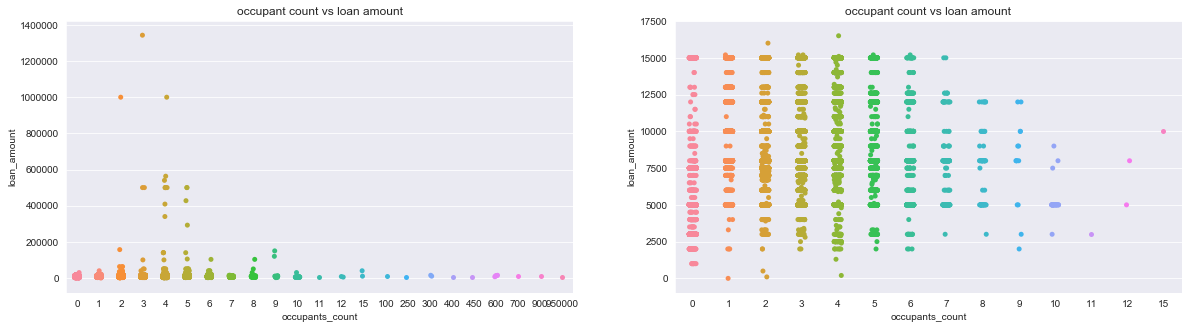

In [42]:
customize_strip_plot(df=df,
                     df_clean=df_clean,
                     y='loan_amount', 
                     x='occupants_count', 
                     title='occupant count vs loan amount')

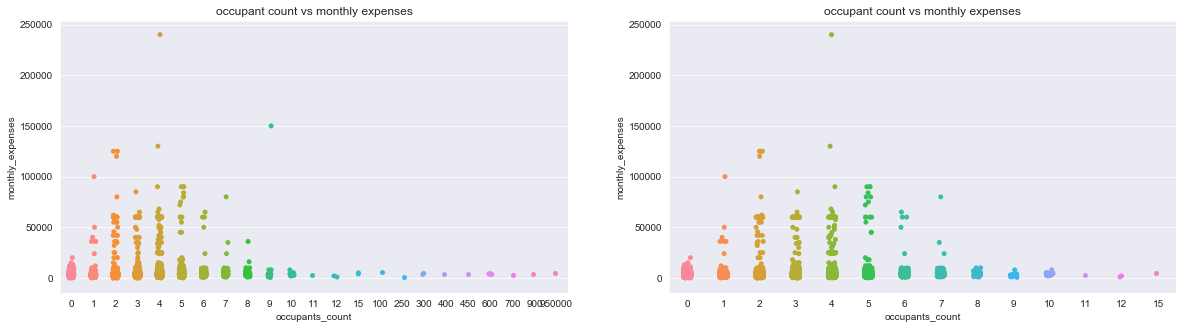

In [43]:
customize_strip_plot(df=df,
                     df_clean=df_clean,
                     y='monthly_expenses', 
                     x='occupants_count', 
                     title='occupant count vs monthly expenses')

Around 75% of the applicant have less than 4 occupants. Higher the number occupants loan amount approved  and monthly espenses seems less 

Applicant has declared occupant count as 0. whats thier dependent_count?

In [44]:
print("Occupant count is 0: ", df_clean[df_clean['occupants_count'] == 0].shape[0])
print ("Occupant count, dependent count is 0: ", df_clean[(df_clean['occupants_count'] == 0) & (df_clean['old_dependents'] == 0) & (df_clean['young_dependents'] == 0)].shape[0]) 

Occupant count is 0:  5267
Occupant count, dependent count is 0:  5260


### Predictor variable `house_area`

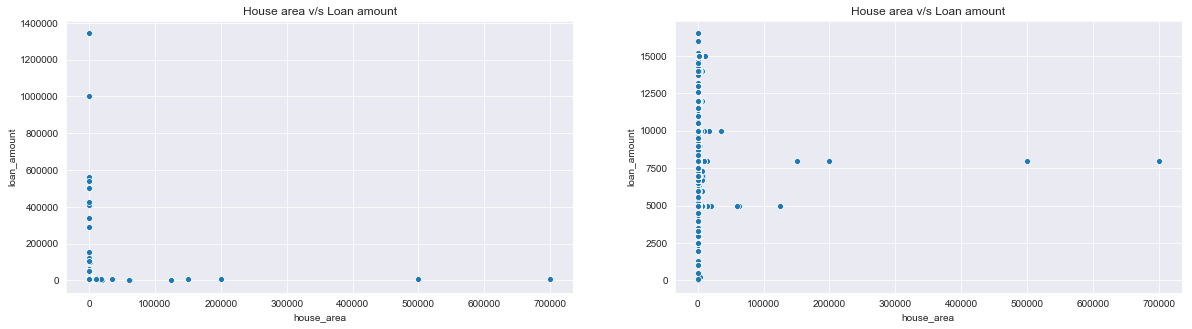

Maximum house area: 700000.0
Minimum house area: 0.0
Mean house area:552.77


In [45]:
customize_scatter_plot(df=df, 
                       df_clean=df_clean, 
                       y='loan_amount',
                       x='house_area',
                       title='House area v/s Loan amount')

# Continous feature - House area
print('Maximum house area:', df.house_area.max())
print('Minimum house area:', df.house_area.min())
print("Mean house area:" + "{:.2f}".format(df.house_area.mean()))

Assuming **house_area** in sqft there are unrealistic values. Binning the values to form discrete data point

In [46]:
df['house_area_band']=0
df.loc[df.house_area == 0, 'house_area_band'] = 0
df.loc[(df.house_area > 0) & (df.house_area <= 500), 'house_area_band'] = 1
df.loc[(df.house_area > 500) & (df.house_area <= 1000), 'house_area_band'] = 2
df.loc[(df.house_area > 1000) & (df.house_area <= 1500), 'house_area_band'] = 3
df.loc[(df.house_area > 1500) & (df.house_area <= 2000), 'house_area_band'] = 4
df.loc[(df.house_area > 2000) & (df.house_area <= 2500), 'house_area_band'] = 5
df.loc[df.house_area > 2500, 'house_area_band'] = 6

df_clean['house_area_band']=0
df_clean.loc[df.house_area == 0, 'house_area_band'] = 0
df_clean.loc[(df.house_area > 0) & (df_clean.house_area <= 500), 'house_area_band'] = 1
df_clean.loc[(df.house_area > 500) & (df_clean.house_area <= 1000), 'house_area_band'] = 2
df_clean.loc[(df.house_area > 1000) & (df_clean.house_area <= 1500), 'house_area_band'] = 3
df_clean.loc[(df.house_area > 1500) & (df_clean.house_area <= 2000), 'house_area_band'] = 4
df_clean.loc[(df.house_area > 2000) & (df_clean.house_area <= 2500), 'house_area_band'] = 5
df_clean.loc[df.house_area > 2500, 'house_area_band'] = 6

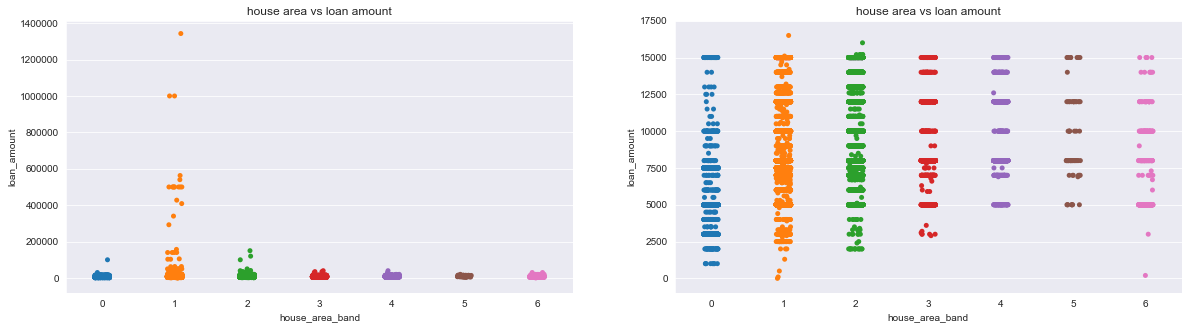

In [47]:
count_percentage_mean(df_clean, "house_area_band","loan_amount")

customize_strip_plot(df=df,
                     df_clean=df_clean,
                     y='loan_amount', 
                     x='house_area_band', 
                     title='house area vs loan amount')

**house_area_band** indicates that applicants with 0 **house_area** have lower average loan amount approved. Higher the house area average loan amount approved seems higher. There seems to be a linear relationship

### Predictor variable `home_ownership`

In [48]:
count_percentage_mean(df, "home_ownership","loan_amount")

,count,percentage,mean
home_ownership,,,
0.0,1090,0.027250,8278.623853
1.0,38531,0.963275,8440.294853


96% of ther applicants own thier house. **home_ownership** is missing for few applicants(Data imputations!)

Is there a relationship between **home_ownership** and monthly expenses?

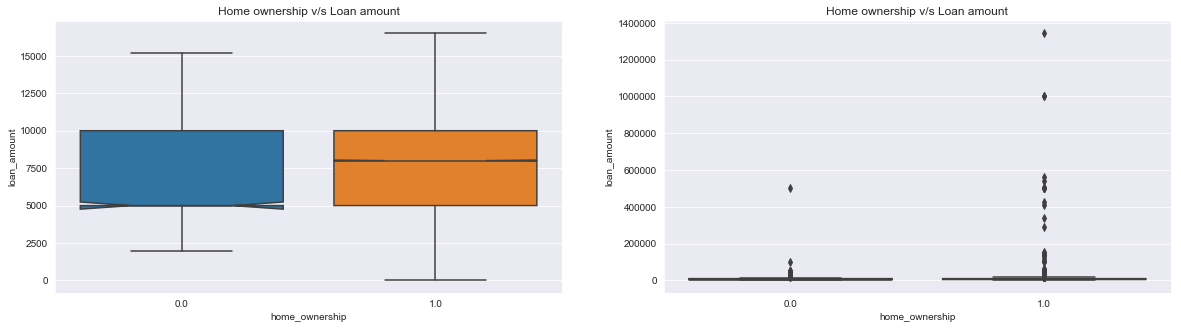

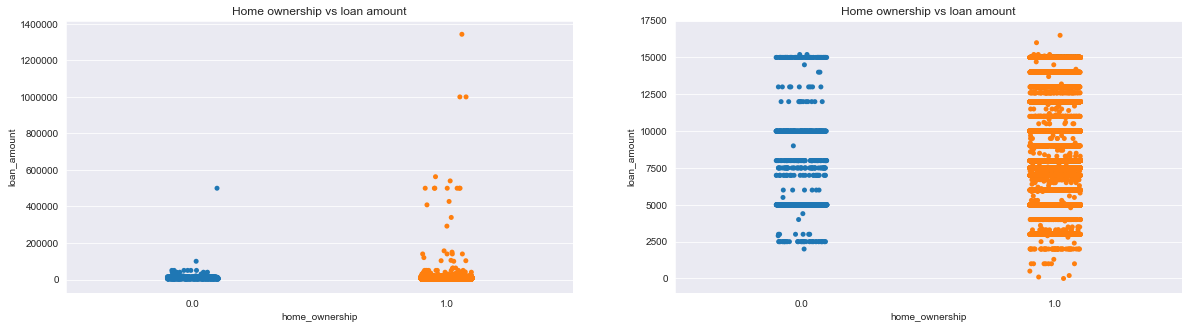

,count,percentage,mean
home_ownership,,,
0.0,1090,0.027250,5103.821527
1.0,38531,0.963275,3773.633385


In [49]:
customize_box_plot(df, 
                   y='loan_amount',
                   x='home_ownership',
                   title='Home ownership v/s Loan amount',
                   notch=True)

customize_strip_plot(df=df,
                     df_clean=df_clean,
                     y='loan_amount', 
                     x='home_ownership', 
                     title='Home ownership vs loan amount')

count_percentage_mean(df, "home_ownership","monthly_expenses")


For the applicants who own house has monthly expenses less than who don't. This could be the reason for the applicants with more occupants with less monthly expenses

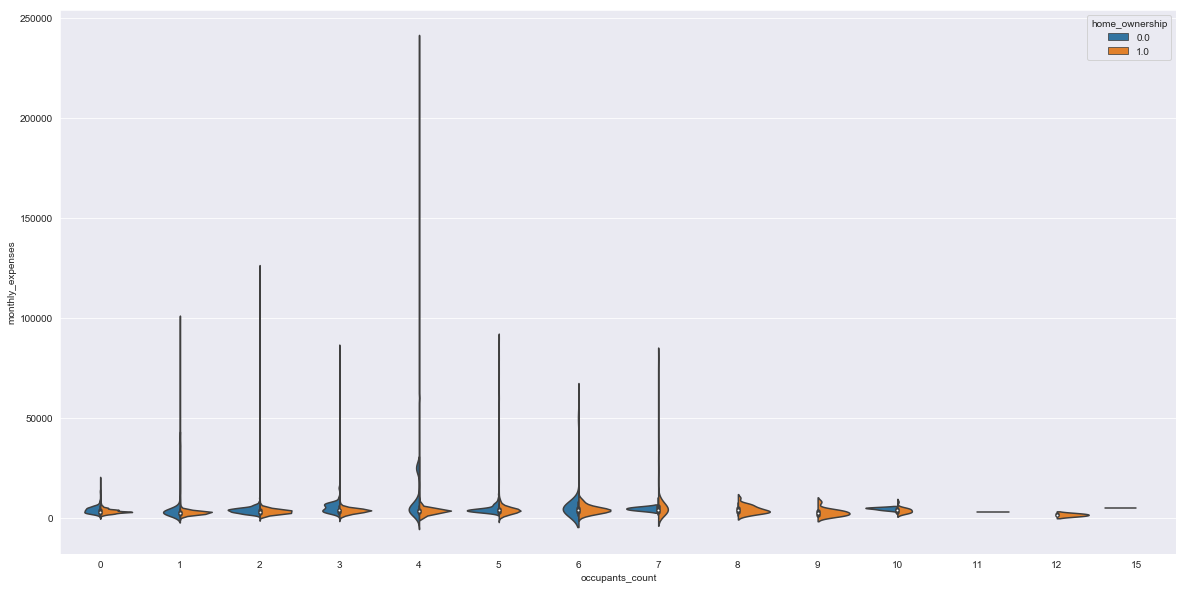

In [50]:
plt.subplots(figsize=(20, 10))
sns.violinplot("occupants_count", "monthly_expenses", 
               hue="home_ownership", 
               data = df_clean,
               split=True)
plt.show()

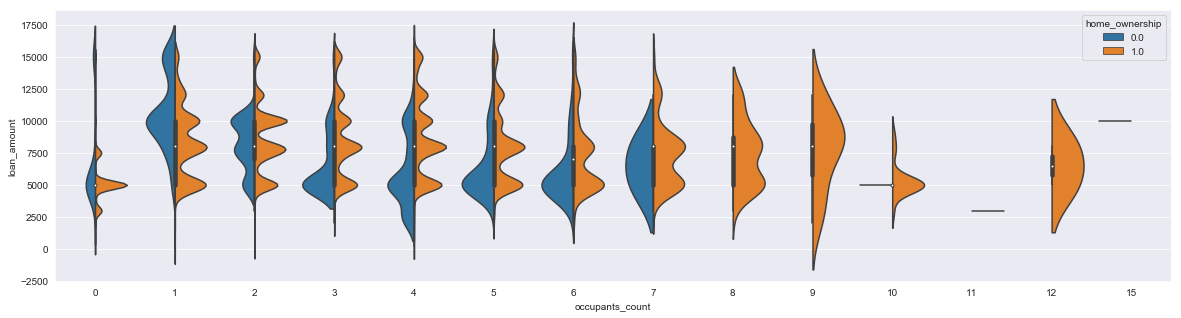

In [51]:
plt.subplots(figsize=(20, 5))
sns.violinplot("occupants_count", "loan_amount", 
               hue="home_ownership", 
               data = df_clean,
               split=True)
plt.show()

It is evident that higher the occupants count,  applicants own thier house

### Predictor variable `age`

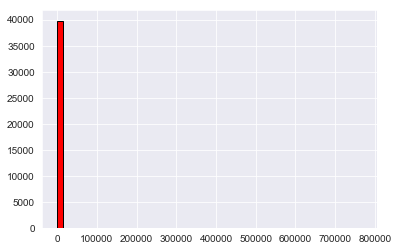

In [52]:
df_clean.age.hist(bins=50,
            edgecolor='black',
            color='red')
plt.show()

There is some unrealistic age which is more than 100. Any age lower than 18 and more than 60 is not eligible for loan.

Dropping the data points for age > 60 and age < 18


In [53]:
df = df.drop(df[df['age'] > 60].index)
df_clean = df_clean.drop(df_clean[df_clean['age'] > 60].index)

df = df.drop(df[df['age'] < 18].index)
df_clean = df_clean.drop(df_clean[df_clean['age'] < 18].index)

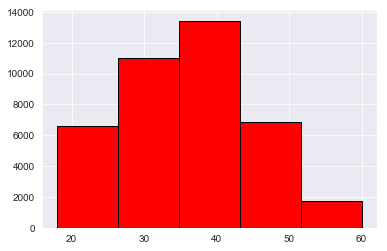

Oldest Applicant: 60 Years
Youngest Applicant : 18 Years
Average Age of the Applicant:35.93 Years


In [54]:
df_clean.age.hist(bins=5,
            edgecolor='black',
            color='red')
plt.show()

# Continous feature - Age
print('Oldest Applicant:', df_clean.age.max(), 'Years')
print('Youngest Applicant :', df_clean.age.min(), 'Years')
print("Average Age of the Applicant:" + "{:.2f}".format(df_clean.age.mean()), 'Years')

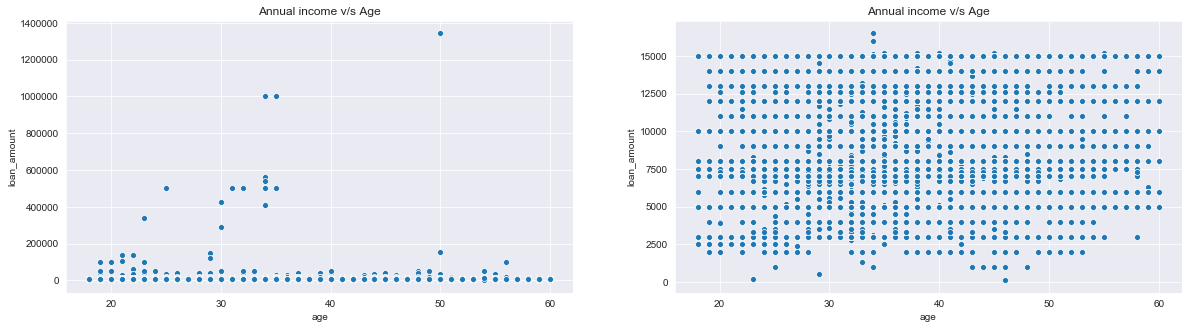

Skewness: 0.234290
Kurtosis: -0.641879


In [55]:
customize_scatter_plot(df=df, 
                       df_clean=df_clean, 
                       y='loan_amount',
                       x='age',
                       title='Annual income v/s Age')

print("Skewness: %f" % df['age'].skew())
print("Kurtosis: %f" % df['age'].kurt())

**age** is modertely skewed. Binning age to form discrete variable

In [56]:
df['age_band']=0
df.loc[(df.age > 18) & (df.age <= 25), 'age_band'] = 1
df.loc[(df.age > 25) & (df.age <= 30), 'age_band'] = 2
df.loc[(df.age > 30) & (df.age <= 35), 'age_band'] = 3
df.loc[(df.age > 35) & (df.age <= 40), 'age_band'] = 4
df.loc[(df.age > 40) & (df.age <= 45), 'age_band'] = 5
df.loc[(df.age > 45) & (df.age <= 50), 'age_band'] = 6
df.loc[(df.age > 50) & (df.age <= 55), 'age_band'] = 7
df.loc[df.age > 55, 'age_band'] = 8

df_clean['age_band']=0
df_clean.loc[(df_clean.age > 18) & (df_clean.age <= 25), 'age_band'] = 1
df_clean.loc[(df_clean.age > 25) & (df_clean.age <= 30), 'age_band'] = 2
df_clean.loc[(df_clean.age > 30) & (df_clean.age <= 35), 'age_band'] = 3
df_clean.loc[(df_clean.age > 35) & (df_clean.age <= 40), 'age_band'] = 4
df_clean.loc[(df_clean.age > 40) & (df_clean.age <= 45), 'age_band'] = 5
df_clean.loc[(df_clean.age > 45) & (df_clean.age <= 50), 'age_band'] = 6
df_clean.loc[(df_clean.age > 50) & (df_clean.age <= 55), 'age_band'] = 7
df_clean.loc[df_clean.age > 55, 'age_band'] = 8

count_percentage_mean(df_clean, "age_band","loan_amount")

,count,percentage,mean
age_band,,,
0,93,0.002344,7575.268817
1,5170,0.130292,7549.110251
2,7472,0.188306,7954.951820
3,7423,0.187072,7990.004041
4,7640,0.192540,8228.010471
5,5959,0.150176,8249.689545
6,3767,0.094934,8280.408813
7,1655,0.041709,8274.138973
8,501,0.012626,8581.037924


There are less than 15% of applicants who are older than 45 years

In [57]:
## Getting the correlation of all the features with target variable. 
(df_clean.corr()**2)["loan_amount"].sort_values(ascending = False)[1:]

annual_income            0.092431
water_availability       0.087887
house_area_band          0.057808
occupants_count          0.046610
sanitary_availability    0.026997
loan_installments        0.018535
n_repayment_due          0.016537
loan_tenure              0.015465
total_dependents         0.014133
young_dependents         0.012886
age_band                 0.005308
age                      0.004918
home_ownership           0.002331
monthly_expenses         0.001531
old_dependents           0.000750
house_area               0.000278
Name: loan_amount, dtype: float64

### Predictor variable of type objects

#### Variable `primary_business`, `secondary_business`, `loan_purpose`  has missing data can be set to none

In [58]:
for col in ['primary_business', 'secondary_business']:
    df[col]=df[col].fillna('none')
print("primary_business is null:", df['primary_business'].isnull().any())
print("secondary_business is null:", df['secondary_business'].isnull().any())

for col in ['primary_business', 'secondary_business']:
    df_clean[col]=df_clean[col].fillna('none')
print("primary_business is null:", df_clean['primary_business'].isnull().any())
print("secondary_business is null:", df_clean['secondary_business'].isnull().any())

primary_business is null: False
secondary_business is null: False
primary_business is null: False
secondary_business is null: False


In [59]:
count_percentage_mean(df_clean, "secondary_business","loan_amount")

,count,percentage,mean
secondary_business,,,
Agriculture,2090,0.052671,7616.267943
Daily wage labourer,2541,0.064037,6991.932310
Livestock rearing,178,0.004486,6247.191011
Others,2541,0.064037,8220.110193
none,32330,0.814768,8165.969688


In [60]:
# There has to be purpose for the loan
# Missing values can specified as others
df['loan_purpose'] = df['loan_purpose'].fillna('Others')
df_clean['loan_purpose'] = df_clean['loan_purpose'].fillna('Others')
print("loan_purpose is null:", df['loan_purpose'].isnull().any())

loan_purpose is null: False


#### Variable `city`, `social_class` has missing data.

* city column will be dropped as it is hard impute the data and how much this variable can contribute? can't be determined for sure.
* Social class will be of important in case of government loan. Missing values are assigned as Others.   

In [61]:
# City 
df['city'] = df['city'].fillna('Unknow')
df_clean['city'] = df_clean['city'].fillna('Unknow')

In [62]:
# Social class 

def clean_social_class(df):
    
    df['social_class'] = df['social_class'].fillna('NOT-REVEALED')
    # Number in the social class can be imputed to not-revealed    
    df.loc[df['social_class'].str.isnumeric(), 'social_class'] = 'NOT-REVEALED'
    df['social_class'] = df['social_class'].str.upper() 
    df['social_class'] = df['social_class'].str.replace('.','')
    df['social_class'] = df['social_class'].str.replace('NIL','NOT-REVEALED')
    df['social_class'] = df['social_class'].str.replace('OPEN','NOT-REVEALED')
    df['social_class'] = df['social_class'].str.replace('NOT AVAILABLE','NOT-REVEALED')

    # There are misspelled cast

    df['social_class'].replace(['SECHUDLE CASTE','SCHUDLE CAST','SCHEDULED CASTE','S C','SCHDULED CAST','HINDU_SC',
                           'SECHUDLE CAST','HARIJAN_SC','SCEDELT CAST','CHAMBHAR-SC','STSC','SCHEDULE CASTE',
                           'ADI KARNATAKA (SC)','STC','SECHUDLED CASTE','MAHAR(SC)','SS',
                           'SECHUDLE TRIPE', 'SCHEDULED TRIBE', 'TRIBAL', 'TRIBEL', 'S T', 'DHANGAR(NOMADIC TRIBE)','DHANGAR(NOMADIC TRIBES)','ST GOND','ST(HARIJAN)'],
                          ['SC','SC','SC','SC','SC','SC','SC','SC','SC','SC','SC','SC','SC','SC','SC','SC','SC''ST','ST','ST','ST','ST','ST','ST','ST','ST','ST'],
                          inplace=True)
    df['social_class'].replace(['GENERAL','GC','GEN','HINDU','GENERAL CASTE','GENL','GENAREL','GENARAL','HINDHU','GENRAL',
                               'GENREL','TELAGU','TAMIL','MADRASI','24 TELUGASHETTY','TELGU','GENAREL CAST','GN','GRN','HINDU, WADDAR',
                               'GENETAL','G','GEBERAL','GEN- BPL'],
                          'GC',
                          inplace=True)

    df['social_class'].replace(['KASAR- OBC','OTHER BACKWARD CASTE','HINDU_OBC','HINDU, KURUBA','0BC','SONAR (OBC)',
                                'OC','OBC`','OGC','O B C','ABC','SBC','OBC','2ND','O'],
                          'OBC',
                          inplace=True)

    df['social_class'].replace(['MUSHLIM','MUSLIM','MUSILIM','ISLAM','MUSILM'],
                               'MUSLIM'
                               ,inplace=True)

    df['social_class'].replace(['CRISTAN','CHRISTAIN','CHRICSHAN'],
                               'CHRISTIAN'
                               ,inplace=True)

    df['social_class'].replace(['MINORITY','MINORITY COMUNITY','MYNORITY',
                               'MYNIRITY','MIONRITY','MINERTY','MYNORETY','MAINOLITY'],
                               'MINORITY'
                               ,inplace=True)

    df['social_class'].replace(['MINORITY','CHRISTIAN','MUSLIM'],
                               'OBC'
                               ,inplace=True)

    df['social_class'].replace(['SC','ST'],
                               'BC'
                               ,inplace=True)

    allowed_vals = ['BC','OBC','GC','NOT-REVEALED']
    df.loc[~df['social_class'].isin(allowed_vals), 'social_class'] = 'OTHERS'
    return df

df = clean_social_class(df)
df_clean = clean_social_class(df_clean)
count_percentage_mean(df_clean, "social_class","loan_amount")


,count,percentage,mean
social_class,,,
BC,9911,0.249773,8653.011805
GC,6226,0.156905,8102.762608
NOT-REVEALED,5510,0.138861,5518.838475
OBC,14914,0.375857,8471.677618
OTHERS,3119,0.078604,8568.900289


In [63]:
# creating social_class_cat to assign numeric values
df['social_class'].replace(['BC', 'OBC', 'OTHERS', 'GC', 'NOT-REVEALED'], [0,1,2,3,4], inplace=True)
df_clean['social_class'].replace(['BC', 'OBC', 'OTHERS', 'GC', 'NOT-REVEALED'], [0,1,2,3,4], inplace=True)

#### Variable `sex`

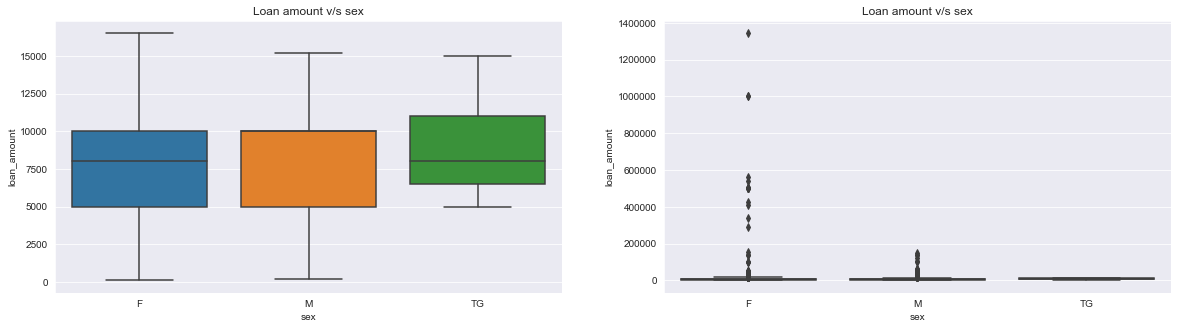

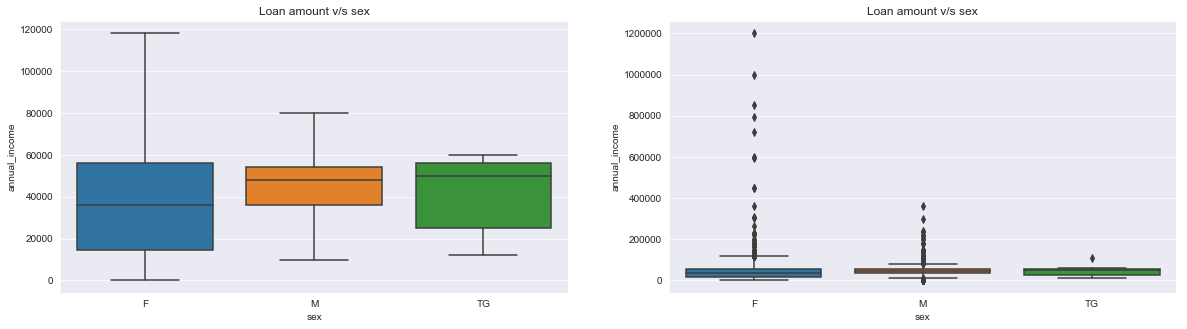

,count,percentage,mean
sex,,,
F,37377,0.941961,36913.735211
M,2296,0.057863,45294.641115
TG,7,0.000176,47485.714286


In [64]:
customize_box_plot(df, 
                   y='loan_amount',
                   x='sex',
                   title='Loan amount v/s sex')
customize_box_plot(df, 
                   y='annual_income',
                   x='sex',
                   title='Loan amount v/s sex')
count_percentage_mean(df_clean, "sex","annual_income")

More than 94% of the applicants are female. Average annual income for female is less than of Male

### Predictor variable `type_of_house`

In [65]:
count_percentage_mean(df_clean, "type_of_house","loan_amount")

,count,percentage,mean
type_of_house,,,
R,6361,0.160307,7916.129539
T1,15000,0.378024,8056.740000
T2,17625,0.444178,8162.382979


**Type of house** 
1. R - Room
2. T1 - Studio apartments
3. T2 - One bedroom

Is there a relationship between home_ownership, type_of_house and water/sanitary availability?

In [66]:
customize_cross_tab([df.sanitary_availability,
            df.water_availability, df.type_of_house],[df.home_ownership])

* Owned houses are mostly T1(37%) or T2(44%)
* There is no house owned with sanitary but no water
* Applicant owns the home without both water and sanitary availability
* Among the applicant who don't have sanitary availability own house
* Most of owned houses has either half or full water availability
* If there is water most like that sanitary is available

Is there a relationship between house_onwership , type_of_house and house_area_band cross tab

In [67]:
customize_cross_tab([df.home_ownership,
            df.type_of_house],
            [df.house_area_band])

If the **house_area** is more than 1000 its likely that they own the house 

Data imputation for **house_owership** for null values 
 If house area is grater than 1000 applicant own thier house
 If the house area is 0 then home_ownership can be considered as 0

In [68]:
df.loc[(df['home_ownership'].isnull()) & (df['house_area'] > 1000), 'home_ownership'] = 1
df.loc[(df['home_ownership'].isnull()) & (df['house_area'] == 0), 'home_ownership'] = 0

df_clean.loc[(df_clean['home_ownership'].isnull()) & (df_clean['house_area'] > 1000), 'home_ownership'] = 1
df_clean.loc[(df_clean['home_ownership'].isnull()) & (df_clean['house_area'] == 0), 'home_ownership'] = 0

Data imputation for **sanitary_availability** if the occupant count is 0 then there is no sanitary_availability

In [69]:
df.loc[(df['sanitary_availability'].isnull()) & (df['occupants_count'] == 0), 'sanitary_availability'] = 0
df_clean.loc[(df_clean['sanitary_availability'].isnull()) & (df_clean['occupants_count'] == 0), 'sanitary_availability']= 0


Data imputation for **type_of_house** by its mode

In [70]:
print("Over all missing values for type_of_house:", df_clean[df_clean['type_of_house'].isnull()].shape[0])
print("Missing values of type_of_house where no sanitary and house is not owned: ", 
      df_clean[(df_clean['type_of_house'].isnull()) & (df_clean['sanitary_availability'] == 0) & (df_clean['home_ownership']==0)].shape[0]) 
print("Missing values of type_of_house where no sanitary and house is owned:", 
df_clean[(df_clean['type_of_house'].isnull()) & (df_clean['sanitary_availability'] == 0) & (df_clean['home_ownership']==1)].shape[0])

Over all missing values for type_of_house: 694
Missing values of type_of_house where no sanitary and house is not owned:  313
Missing values of type_of_house where no sanitary and house is owned: 381


In [71]:
def clean_type_of_house(df):
    df.loc[(df['type_of_house'].isnull()) & (df['sanitary_availability'] == 0) & (df['home_ownership']==0) ,
           'type_of_house'] =df[(df['sanitary_availability'] == 0) & (df['home_ownership']==0)].type_of_house.mode()[0]
    df.loc[(df['type_of_house'].isnull()) & (df['sanitary_availability'] == 0) & (df['home_ownership']==1) ,
           'type_of_house'] =df[(df['sanitary_availability'] == 0) & (df['home_ownership']==1)].type_of_house.mode()[0]
    return df

df = clean_type_of_house(df)
df_clean = clean_type_of_house(df_clean)

Data imputation for **water_availability**, If they applicant owns house then most likely to have water availability wither full or half taking the mode of the water avaibility

In [72]:
def clean_water_availability(df):
    df.loc[(df['water_availability'].isnull()) & (df['sanitary_availability'] == 0) & (df['home_ownership']==0), 
       'water_availability'] = df[(df['sanitary_availability'] == 0) & (df['home_ownership']==0)].water_availability.mode()[0]

    df.loc[(df['water_availability'].isnull()) & (df['sanitary_availability'] == 0) & (df['home_ownership']==1), 
       'water_availability'] = df[(df['sanitary_availability'] == 0) & (df['home_ownership']==1)].water_availability.mode()[0]
    return df

df = clean_water_availability(df)
df_clean = clean_water_availability(df_clean)


Data imputaion for **monthly_expenses**

* Monthly expenses are higher for applicant who don't own house
* Monthly expenses are less for T2 types of house as most of the T2 houses are owned 
* Filling the missing values with mean of the monthly expenses 

In [73]:
df['monthly_expenses'] = df['monthly_expenses'].fillna(df['monthly_expenses'].mean())
df_clean['monthly_expenses'] = df_clean['monthly_expenses'].fillna(df_clean['monthly_expenses'].mean())

In [74]:
# Changeing the string values to numeric

def change_to_numeric(df):
    df['sex'].replace(['F', 'M', 'TG'], [0,1,2], inplace=True)
    df['type_of_house'].replace(['R', 'T1', 'T2'], [0,1,2], inplace=True)
    df['repayment_behaviour'].replace(['Excellent', 'Very_Good', 'Good', 'Fair', 'poor','Bad'], [1,2,3,4,5,6], inplace=True)
    df.loc[~df['primary_business'].isin(['none']), 'primary_business'] = 1
    df.loc[df['primary_business'].isin(['none']), 'primary_business'] = 0
    df.loc[~df['secondary_business'].isin(['none']), 'secondary_business'] = 1
    df.loc[df['secondary_business'].isin(['none']), 'secondary_business'] = 0
    df.loc[~df['loan_purpose'].isin(['none']), 'loan_purpose'] = 1
    df.loc[df['loan_purpose'].isin(['none']), 'loan_purpose'] = 0
    return df

df = change_to_numeric(df)
df_clean = change_to_numeric(df_clean)


In [75]:
# Missing data 
total = df_clean.isnull().sum().sort_values(ascending=False)
percent = (df_clean.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
age_band,0,0.0
house_area_band,0,0.0
age,0,0.0
sex,0,0.0
social_class,0,0.0
primary_business,0,0.0
secondary_business,0,0.0
annual_income,0,0.0
monthly_expenses,0,0.0
old_dependents,0,0.0


In [76]:
df.head()

,city,age,sex,social_class,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,young_dependents,...,loan_purpose,loan_tenure,loan_installments,loan_amount,loan_amount_band,n_repayment_due,repayment_behaviour,total_dependents,house_area_band,age_band
0,Dhanbad,22,0,2,1,1,36000.0,5000.0,0,2,...,1,12,12,5000.0,<5K,0,2,2,1,1
1,Manjapra,21,0,1,1,0,94000.0,3600.0,1,1,...,1,12,50,7500.0,5K~10K,38,5,2,1,1
2,Dhanbad,24,1,2,1,1,48000.0,4000.0,0,2,...,1,12,12,5000.0,<5K,0,2,2,1,1
3,Unknow,26,0,1,1,0,7000.0,5000.0,0,2,...,1,12,50,7500.0,5K~10K,38,5,2,1,2
4,Nuapada,23,0,1,1,1,36000.0,3500.0,0,0,...,1,12,12,5000.0,<5K,0,2,0,1,1


In [77]:
## Calculating Mean Squared Error(MSE) by estimating the average value of the loan_amount

df_sample=df.copy()
df_sample['mean_loan_amount'] = (df_sample['loan_amount']).mean()
df_sample['mse'] =((df_sample['mean_loan_amount'] - df_sample['loan_amount'])/len(df_sample))**2
print("Mean Squared Error(MSE) for average line is : {}".format(df_sample.mse.mean()))

Mean Squared Error(MSE) for average line is : 0.116550608031822


### Predictions

In [78]:
df = df.drop(['city', 
              'house_area', 
              'age',
              'n_repayment_due',
              'loan_amount_band'], 
                         axis=1)

df_clean = df_clean.drop(['city', 
              'house_area', 
              'age',
              'n_repayment_due',
              'loan_amount_band'], 
                         axis=1)

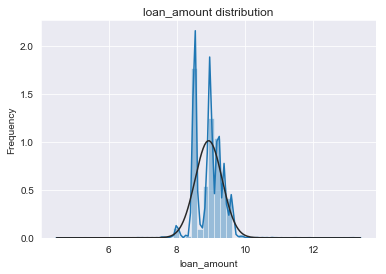

mu : 8.9329 and sigma : 0.3946


In [79]:
# log tranformation can be used to normalize the 
# positively/right skewed ditribution 
# remove the outlier for loan_amount
df = df.drop(df[df['loan_amount'] >= 1000000].index)

df["loan_amount"]= np.log1p(df["loan_amount"])

# new distribution
sns.distplot(df['loan_amount'], fit = norm)
plt.ylabel('Frequency')
plt.title('loan_amount distribution')
plt.show()

# Fitted paramter used by the function
mu,sigma = norm.fit(df['loan_amount'])
print(f"mu : {mu:.4f} and sigma : {sigma:.4f}")

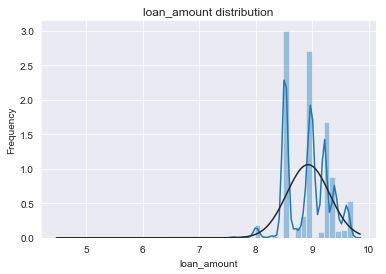

mu : 8.9255 and sigma : 0.3765


In [80]:
# log tranformation can be used to normalize the 
# positively/right skewed ditribution 
# remove the outlier for loan_amount
df_clean = df_clean.drop(df_clean[df_clean['loan_amount'] >= 1000000].index)

df_clean["loan_amount"]= np.log1p(df_clean["loan_amount"])

# new distribution
sns.distplot(df_clean['loan_amount'], fit = norm)
plt.ylabel('Frequency')
plt.title('loan_amount distribution')
plt.show()

# Fitted paramter used by the function
mu,sigma = norm.fit(df_clean['loan_amount'])
print(f"mu : {mu:.4f} and sigma : {sigma:.4f}")

In [81]:
## Fixing Skewed features using boxcox transformation. 

def fixing_skewness(df):    
    numeric_feats = df.dtypes[df.dtypes != "object"].index
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))

fixing_skewness(df)
fixing_skewness(df_clean)

numeric_features = df.dtypes[df.dtypes != "object"].index
skewed_feats = df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
skewed_feats = df_clean[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)

In [82]:
from sklearn.model_selection import train_test_split

X= df.drop(['loan_amount'], axis=1).values
y= df['loan_amount'].values

X_train, X_val, y_train, y_val = train_test_split(X, y,test_size = .20, random_state = 0)

In [90]:
# KFold cross validation 

n_folds = 5
def rmse_cv(model,X,y):
    kf = KFold(n_folds, shuffle = True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X, y, 
                                    scoring="neg_mean_squared_error", 
                                    cv=kf))
    return rmse

n_folds = 5
custom_cv = KFold(n_folds, shuffle=True, random_state=42)

def print_model_stats(model):
    print("Training RMSE : %.4f" % rmse_cv(model, X_train, y_train).mean())
    print("Training MSE : %.4f" % mean_squared_error(y_train, model.predict(X_train)))
    print("Training MAE : %.4f" % mean_absolute_error(y_train, model.predict(X_train)))
    print("Training R^2 : %.4f" % r2_score(y_train, model.predict(X_train)))
    print("Validation RMSE : %.4f" % rmse_cv(model, X_val, y_val).mean())
    print("Validation R^2 : %.4f" % r2_score(y_val, model.predict(X_val)))
    print("Validation MSE : %.4f" % mean_squared_error(y_val, model.predict(X_val)))
    print("Validation MAE: %.4f" % mean_absolute_error(y_val,model.predict(X_val)))

## Linear regression

In [91]:
start_time = time.time()
lm_model = LinearRegression()
lm_model.fit(X_train,y_train)
print("Training time : %.4f" % (time.time() - start_time), " seconds")
print_model_stats(lm_model)

Training time : 0.0147  seconds
Training RMSE : 0.3269
Training MSE : 0.1060
Training MAE : 0.2445
Training R^2 : 0.3182
Validation RMSE : 0.3252
Validation R^2 : 0.3278
Validation MSE : 0.1053
Validation MAE: 0.2417


## Gradient Boosting Regressor

In [92]:
start_time = time.time()

GBR_model = GradientBoostingRegressor(n_estimators=3000,
                               learning_rate = 0.08,
                               max_depth = 4,
                               max_features = 'sqrt',
                               min_samples_leaf = 15,
                               min_samples_split=10,
                               loss='huber', 
                               random_state=5)

GBR_model.fit(X_train, y_train)
print("Training time : %.4f" % (time.time() - start_time), " seconds")
print_model_stats(GBR_model)

Training time : 45.8888  seconds
Training RMSE : 0.2513
Training MSE : 0.0545
Training MAE : 0.1620
Training R^2 : 0.6494
Validation RMSE : 0.2688
Validation R^2 : 0.5943
Validation MSE : 0.0636
Validation MAE: 0.1758


## Decision Tree

In [86]:
start_time = time.time()
DTR_model = DecisionTreeRegressor(max_depth=50,
                                 min_samples_leaf=10,
                                 min_samples_split=4,
                                 max_features='sqrt')
DTR_model.fit(X_train,y_train)
print("Training time : %.4f" % (time.time() - start_time), " seconds")
print_model_stats(DTR_model)

Training time : 0.0194  seconds
Training MSE : 0.0678
Training MAE : 0.1821
Training R^2 : 0.5639
Validation R^2 : 0.4978
Validation MSE : 0.0787
Validation MAE: 0.1947


Variable: social_class         Importance: 0.28
Variable: annual_income        Importance: 0.14
Variable: water_availability   Importance: 0.12
Variable: monthly_expenses     Importance: 0.08
Variable: loan_tenure          Importance: 0.07
Variable: type_of_house        Importance: 0.06
Variable: loan_amount          Importance: 0.05
Variable: total_dependents     Importance: 0.04
Variable: secondary_business   Importance: 0.03
Variable: occupants_count      Importance: 0.03
Variable: sanitary_availability Importance: 0.03
Variable: loan_installments    Importance: 0.02
Variable: house_area_band      Importance: 0.02
Variable: sex                  Importance: 0.01
Variable: young_dependents     Importance: 0.01
Variable: repayment_behaviour  Importance: 0.01
Variable: primary_business     Importance: 0.0
Variable: old_dependents       Importance: 0.0
Variable: home_ownership       Importance: 0.0
Variable: loan_purpose         Importance: 0.0


Text(0.5,1,'Variable Importance')

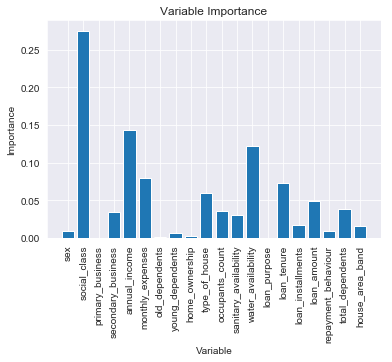

In [87]:
feature_list = list(df.columns)
importances = list(DTR_model.feature_importances_)
feature_importances = [(feature, round(importance,2)) for feature, 
                      importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, 
                             key = lambda x:x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importance')

## Random Forest

In [88]:
start_time = time.time()
RFR_model = RandomForestRegressor(min_samples_leaf=2,
                                 min_samples_split=2,
                                 max_features='sqrt',
                                 max_depth=50,
                                 bootstrap=False,
                                 n_estimators=800)
RFR_model.fit(X_train,y_train)
print("Training time : %.4f" % (time.time() - start_time), " seconds")
print_model_stats(RFR_model)

Training time : 20.1001  seconds
Training MSE : 0.0281
Training MAE : 0.1148
Training R^2 : 0.8194
Validation R^2 : 0.6385
Validation MSE : 0.0566
Validation MAE: 0.1671


Variable: annual_income        Importance: 0.21
Variable: water_availability   Importance: 0.12
Variable: monthly_expenses     Importance: 0.11
Variable: occupants_count      Importance: 0.1
Variable: total_dependents     Importance: 0.08
Variable: social_class         Importance: 0.07
Variable: loan_installments    Importance: 0.05
Variable: type_of_house        Importance: 0.04
Variable: sanitary_availability Importance: 0.04
Variable: loan_tenure          Importance: 0.04
Variable: house_area_band      Importance: 0.04
Variable: secondary_business   Importance: 0.03
Variable: loan_amount          Importance: 0.03
Variable: young_dependents     Importance: 0.02
Variable: repayment_behaviour  Importance: 0.02
Variable: sex                  Importance: 0.01
Variable: home_ownership       Importance: 0.01
Variable: primary_business     Importance: 0.0
Variable: old_dependents       Importance: 0.0
Variable: loan_purpose         Importance: 0.0


Text(0.5,1,'Variable Importance')

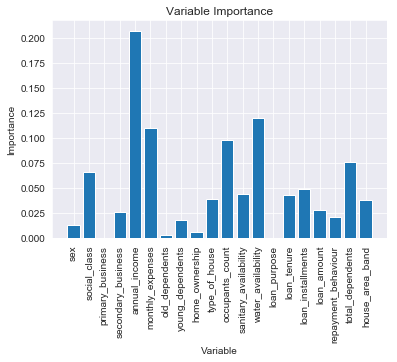

In [89]:
importances = list(RFR_model.feature_importances_)
feature_importances = [(feature, round(importance,2)) for feature, 
                      importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, 
                             key = lambda x:x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importance')

**----------------------------------------------------------------------------**

## Model Observations

Model is suffering from overfiting. Should consider tree pruning, Feature selection, regularization. 

Important features:
---------------------
annual_income        
water_availability   
monthly_expenses     
occupants_count      
total_dependents     
social_class         
loan_installments    
type_of_house        
sanitary_availability       
loan_tenure       
house_area_band        


**Pending tasks**
1. Max loan amount prediction without using ML 
2. Analyse the primary_business, secondary_business and loan purpose to understand whether the varible can be used for
predictions
3. Improve Prediction accuracy 

In [100]:
# Building the model with important features 
X_imp= df.drop(['loan_amount', 'loan_purpose', 'old_dependents','young_dependents','home_ownership','primary_business', 'repayment_behaviour','sex', 'house_area_band', 'loan_tenure'], axis=1).values
y_imp= df['loan_amount'].values

X_train, X_val_imp, y_train, y_val = train_test_split(X_imp, y_imp,test_size = .20, random_state = 0)


In [101]:
start_time = time.time()
lm_model = LinearRegression()
lm_model.fit(X_train,y_train)
print("Training time : %.4f" % (time.time() - start_time), " seconds")
print_model_stats(lm_model)

Training time : 0.0061  seconds
Training RMSE : 0.3306
Training MSE : 0.1092
Training MAE : 0.2484
Training R^2 : 0.2974
Validation RMSE : 0.3269
Validation R^2 : 0.3162
Validation MSE : 0.1071
Validation MAE: 0.2453


In [103]:
start_time = time.time()
RFR_model = RandomForestRegressor(min_samples_leaf=2,
                                 min_samples_split=2,
                                 max_features='sqrt',
                                 max_depth=50,
                                 bootstrap=False,
                                 n_estimators=800)
RFR_model.fit(X_train,y_train)
print("Training time : %.4f" % (time.time() - start_time), " seconds")
print_model_stats(RFR_model)

Training time : 20.2898  seconds
Training RMSE : 0.2541
Training MSE : 0.0275
Training MAE : 0.1115
Training R^2 : 0.8231
Validation RMSE : 0.2724
Validation R^2 : 0.6102
Validation MSE : 0.0611
Validation MAE: 0.1711
